# Testing the Integrated Simulation Platform
This notebook contains codes to test the various functionalities of the integrated simulation platform. You can call any of the modules from the package here. 

In [1]:
#Go to the main directory
#!pip install --editable . 
#!pip install pandas
# !pip install wntr
# !pip install pandapower
# !pip install sklearn

#to find requirements
#depfinder -y .

In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/tmp/ipykernel_133628/3341618488.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Import required packages

In [3]:
from pathlib import Path
from infrarisk.src.network_recovery import *
import infrarisk.src.simulation as simulation
from infrarisk.src.physical.integrated_network import *
import infrarisk.src.recovery_strategies as strategies

from infrarisk.src.physical.interdependencies import *

from infrarisk.src.optimizer import *
import infrarisk.src.plots as model_plots

#hide warnings
import warnings
warnings.filterwarnings('ignore')

/opt/miniconda/envs/infrarisk/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Create an IntegratedNetwork object

In [4]:
payne_city_network = IntegratedNetwork(name = 'PayneCity')

### Load the three infrastructure models: Water, Power and Transportation

Three different models are used:
- Water distribution network using **wntr** package
- Power systems using **pandapower** package
- Transportation network using static traffic assignment package developed by Dr. Stephen Boyles (University of Texas at Austin)

In [5]:
MAIN_DIR = Path('../..')
SIM_STEP = 60
network_dir= 'infrarisk/data/networks/payne_city'
water_folder = MAIN_DIR/f'{network_dir}/water/med'
power_folder = MAIN_DIR/f'{network_dir}/power/low'
transp_folder = MAIN_DIR/f'{network_dir}/transportation/high'

# load all infrastructure networks
payne_city_network.load_networks(water_folder, 
                                 power_folder, 
                                 transp_folder, 
                                 sim_step=SIM_STEP)

Water network successfully loaded from ../../infrarisk/data/networks/payne_city/water/med/water.inp. The analysis type is set to PDA.
initial simulation duration: 60s; hydraulic time step: 60s; pattern time step: 3600s

Power system successfully loaded from ../../infrarisk/data/networks/payne_city/power/low/power.json. Single phase power flow simulation will be used.

Transportation network successfully loaded from ../../infrarisk/data/networks/payne_city/transportation/high. Static traffic assignment method will be used to calculate travel times.


### Create a Networkx graph of the integrated infrastructure network.

In [6]:
payne_city_network.generate_integrated_graph()

Successfully added power network to the integrated graph...
Successfully added water network to the integrated graph...
Successfully added transportation network to the integrated graph...
Integrated graph successfully created.
Generating betweenness centrality...


Loading BokehJS ...

### Build interdependencies

Three types of dependencies:
- Power - Water dependencies (eg.: water pump on electric motor, generator on reservoir)
- Power - Transportation dependencies (eg.: road access to power system components for M&R)
- Water - Transportation dependencies (eg.: road access to water network components for M&R)

The dependencies are referenced using two tables in the model.
- **wp_table** for water - power dependencies
- **access_table** for transportation dependencies

In [7]:
dependency_file = MAIN_DIR/f"{network_dir}/dependencies.csv"
payne_city_network.generate_dependency_table(dependency_file = dependency_file)
payne_city_network.dependency_table.wp_table

,water_id,power_id,water_type,power_type
0,W_WP1,P_MP1,Pump,Motor
1,W_WP2,P_MP1,Pump,Motor
2,W_WP3,P_MP1,Pump,Motor
3,W_WP4,P_MP1,Pump,Motor
4,W_WP5,P_MP2,Pump,Motor
5,W_WP6,P_MP2,Pump,Motor
6,W_WP7,P_MP2,Pump,Motor
7,W_WP8,P_MP3,Pump,Motor


In [8]:
payne_city_network.dependency_table.access_table.head()

,origin_id,transp_id,origin_cat,origin_type,access_dist
0,P_B0,T_J57,power,Bus,84.79
1,P_B1,T_J57,power,Bus,16.96
2,P_B2,T_J57,power,Bus,178.04
3,P_B3,T_J56,power,Bus,27.57
4,P_B4,T_J56,power,Bus,170.80


In [9]:
# dill.dump_session('sessions/payne_city_no_optimization.db')
# dill.load_session('sessions/payne_city_no_optimization.db')

### Set failed components

In [10]:
scenario_folder = "scenarios/track1"
disruption_file = MAIN_DIR/f"{network_dir}/{scenario_folder}/disruption_file.csv"

payne_city_network.set_disrupted_components(disruption_file=disruption_file)
payne_city_network.get_disrupted_components()

['W_PMA732',
 'W_PMA647',
 'W_PMA549',
 'W_PMA524',
 'W_PMA802',
 'P_L340',
 'P_L333',
 'P_L56',
 'P_L310',
 'P_L325',
 'T_L72',
 'T_L80',
 'T_L86',
 'T_L79']

### Deploy recovery crews
We can deploy as many repairs crews as possible. However, beyond a point, increasing the number of crews will not improve the performance of the system.

In [11]:
crew_count = 1
payne_city_network.deploy_crews(
    init_power_crew_locs=['T_J8']*crew_count, 
    init_water_crew_locs=['T_J8']*crew_count,
    init_transpo_crew_locs= ['T_J8']*crew_count
    )

Power repair crews successfully deployed.
Water repair crews successfully deployed.
Transportation repair crews successfully deployed.


### Disrupted components and initial crew locations

In [12]:
model_plots.plot_disruptions_and_crews(payne_city_network)

{'power': ['P_L325', 'P_L56', 'P_L340', 'P_L310', 'P_L333'], 'water': ['W_PMA802', 'W_PMA549', 'W_PMA524', 'W_PMA647', 'W_PMA732'], 'transpo': ['T_L72', 'T_L86', 'T_L80', 'T_L79']}


Loading BokehJS ...

## Simulation of interdependent effects using a test scenario
### (a) Create NetworkRecovery

In [13]:
network_recovery = NetworkRecovery(payne_city_network, 
                                   sim_step=SIM_STEP, 
                                   pipe_close_policy="repair",
                                   pipe_closure_delay= 10, 
                                   line_close_policy="sensor_based_line_isolation",
                                   line_closure_delay= 10)

### (b) Create a simulation object

In [14]:
bf_simulation = simulation.NetworkSimulation(network_recovery)

### (c) Generation of random repair order

In [15]:
strategy = 'capacity'
capacity_strategy = strategies.HandlingCapacityStrategy(payne_city_network)
capacity_strategy.set_repair_order()
repair_order = capacity_strategy.get_repair_order()

import os
if not os.path.exists(MAIN_DIR/f"{network_dir}/{scenario_folder}/capacity"):
    os.makedirs(MAIN_DIR/f"{network_dir}/{scenario_folder}/capacity")

In [16]:
#Generate a random repair order
# repair_order = network_recovery.network.get_disrupted_components()
# repair_orders = pd.read_csv(MAIN_DIR/f"{network_dir}/{scenario_folder}/repair_strategies.csv")
# repair_order = list(repair_orders["capacity"])
#random.shuffle(repair_order)
print('Current repair order is {}'.format(repair_order))

Current repair order is ['T_L72', 'T_L80', 'T_L86', 'T_L79', 'P_L56', 'P_L325', 'P_L340', 'P_L310', 'P_L333', 'W_PMA802', 'W_PMA647', 'W_PMA524', 'W_PMA549', 'W_PMA732']


### (d) Generation of event tables

In [17]:
bf_simulation.network_recovery.schedule_recovery(repair_order)

Components yet to repair 4
Repair T_L72: The transpo crew 1 is at T_J8 at t = 2.0 minutes. It takes 15 minutes to reach nearest node T_J28, the nearest transportation node from T_L72.


Components yet to repair 3
Repair T_L80: The transpo crew 1 is at T_J28 at t = 377.0 minutes. It takes 11 minutes to reach nearest node T_J27, the nearest transportation node from T_L80.


Components yet to repair 2
Repair T_L86: The transpo crew 1 is at T_J27 at t = 748.0 minutes. It takes 14 minutes to reach nearest node T_J33, the nearest transportation node from T_L86.


Components yet to repair 1
Repair T_L79: The transpo crew 1 is at T_J33 at t = 1122.0 minutes. It takes 12 minutes to reach nearest node T_J34, the nearest transportation node from T_L79.


Components yet to repair 10
Repair P_L56: The power crew 1 is at T_J8 at t = 2.0 minutes. It takes 18 minutes to reach nearest node T_J3, the nearest transportation node from P_L56.


Components yet to repair 9
Repair P_L325: The power crew 1 is 

In [18]:
#bf_simulation.network_recovery.event_table.to_csv("event_tbl.csv", sep = "\t", index = False)
bf_simulation.expand_event_table()

### (e) Simulation of interdependent effects

In [19]:
resilience_metrics = bf_simulation.simulate_interdependent_effects(
    bf_simulation.network_recovery)

Time instances for which simulations will be performed:
 [60, 180, 1020, 1260, 1380, 19140, 19260, 19380, 19980, 22500, 22620, 22740, 22860, 22980, 23100, 23340, 23940, 37860, 37980, 38100, 38820, 44820, 44940, 45060, 45420, 45540, 45660, 45780, 46260, 56700, 56820, 56940, 57900, 67260, 67380, 67500, 67740, 67860, 67980, 68100, 68580, 75780, 75900, 76020, 76860, 89580, 89700, 89820, 90060, 90180, 90300, 91140, 94740, 94860, 94980, 112620, 112740]
Simulating network conditions at 60/112740 s...
Simulation time:  60.0 ; Hydraulic time step:  60.0 ; Report time step:  60
Updating status of directly affected components between 60.0 and 180.0...
******************

Simulating network conditions at 180/112740 s...
Simulation time:  180.0 ; Hydraulic time step:  60.0 ; Report time step:  60
Updating status of directly affected components between 180.0 and 1020.0...
The weighted AUC value based on ECS is 0.004
The weighted AUC value based on PCS is 0.004
******************

Simulating network 

In [20]:
strategy = 'capacity'
bf_simulation.write_results(f"{MAIN_DIR}/{network_dir}/{scenario_folder}/{strategy}", 
                            resilience_metrics)

The simulation results successfully saved to ../../infrarisk/data/networks/payne_city/scenarios/track1/capacity


### (f) Calculation of resilience metric

In [21]:
resilience_metrics.calculate_power_resmetric(network_recovery)

In [22]:
resilience_metrics.calculate_water_resmetrics(network_recovery)

# Plot network performance during the disruption

### Overall system performance considering indirect effects

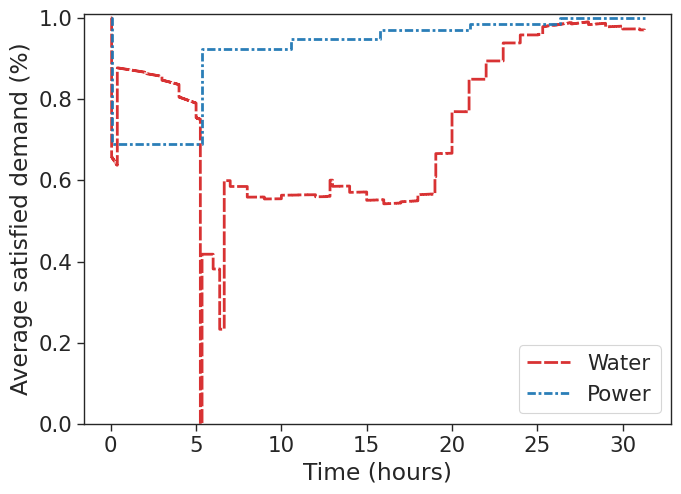

In [23]:
model_plots.plot_interdependent_effects(resilience_metrics, metric = 'pcs', title = False)

### Building-level water outage hours

In [24]:
model_plots.plot_network_impact_map(resilience_metrics = resilience_metrics, 
                                    integrated_network = payne_city_network, 
                                    strategy = strategy, 
                                    node_prefix = "W_JTN", 
                                    infra = "water", 
                                    time_index = None)

Loading BokehJS ...

### Building-level power outage hours 

In [25]:
model_plots.plot_network_impact_map(resilience_metrics, 
                                    integrated_network = payne_city_network, 
                                    strategy = strategy, 
                                    node_prefix= "P_LO", 
                                    infra = "power",
                                    time_index=None)

Loading BokehJS ...

In [26]:
power_df = resilience_metrics.power_demand_ratio.transpose()
power_df['name'] = power_df.index
power_df = power_df.reset_index(drop=True)

from shapely.geometry import Point
import bisect
import seaborn as sns

load_geo_dict = dict()
for index, load in enumerate(payne_city_network.pn.load.name):
    load_geo_dict[load] = Point([payne_city_network.pn.loads_geodata.x[index], 
                                 payne_city_network.pn.loads_geodata.y[index]])
power_df['geometry'] = power_df['name'].map(load_geo_dict)
power_gdf = gpd.GeoDataFrame(power_df, geometry='geometry')
power_gdf.columns = resilience_metrics.power_time_list + ['name', 'geometry']

In [27]:
water_df = resilience_metrics.water_demands_ratio.transpose()
water_df['name'] = water_df.index
water_df = water_df.reset_index(drop=True)

from shapely.geometry import Point, LineString
import bisect
from matplotlib.colors import ListedColormap

junc_geo_dict = dict()
demand_juncs = [x for x in resilience_metrics.water_demands_ratio.columns if x.startswith('W_JTN')]
for index, junc in enumerate(demand_juncs):
    junc_geo_dict[junc] = Point([payne_city_network.integrated_graph.nodes[junc]["coord"][0], 
                                payne_city_network.integrated_graph.nodes[junc]["coord"][1]])
water_df['geometry'] = water_df['name'].map(junc_geo_dict)
water_gdf = gpd.GeoDataFrame(water_df, geometry='geometry')
water_gdf.columns = resilience_metrics.water_time_list + ['name', 'geometry']
print(water_gdf.columns)

Index([       0.0,        1.0,        2.0,        3.0,        4.0,        5.0,
              6.0,        7.0,        8.0,        9.0,
       ...
           1870.0,     1871.0,     1872.0,     1873.0,     1874.0,     1875.0,
           1876.0,     1877.0,     'name', 'geometry'],
      dtype='object', length=1880)


In [28]:
link_names = []
geometry = []
for start, end, data in payne_city_network.integrated_graph.edges(data=True):
    link_names.append(payne_city_network.integrated_graph.edges[start, end]['id'])
    geometry.append(LineString([Point(payne_city_network.integrated_graph.nodes[start]['coord'][0],
                            payne_city_network.integrated_graph.nodes[start]['coord'][1]),
                           Point(payne_city_network.integrated_graph.nodes[end]['coord'][0],
                           payne_city_network.integrated_graph.nodes[end]['coord'][1])]))

link_df = pd.DataFrame({'name': link_names, 'geometry': geometry})
link_gdf = gpd.GeoDataFrame(link_df, geometry='geometry')

In [ ]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as colors
import matplotlib.patches as mpatches

time_intervals = range(0, int(resilience_metrics.water_time_list[-1]), 60)
for index, time in enumerate([33*60, 34*60, 35*60, 36*60]): #time_intervals:
#for index, time in enumerate(time_intervals[0:33]):
    print(index, time, end = ',')
    
    status = []
    for _, row in link_gdf.iterrows():
        
        if row['name'] in payne_city_network.disrupted_components.tolist():
            disrupt_time = network_recovery.event_table_wide[network_recovery.event_table_wide['component'] == row['name']]['disrupt_time'].values[0]
            repair_start = network_recovery.event_table_wide[network_recovery.event_table_wide['component'] == row['name']]['repair_start'].values[0]
            functional_start = network_recovery.event_table_wide[network_recovery.event_table_wide['component'] == row['name']]['functional_start'].values[0]
            #print(row['name'], disrupt_time, repair_start, functional_start)
            if disrupt_time/60 <= time < repair_start/60:
                status.append("Disrupted")
            elif repair_start/60 <= time < functional_start/60:
                status.append("Repairing")
            elif time >= functional_start/60:
                status.append("Restored")
            else:
                status.append("Unaffected")
        else:
            status.append("Unaffected")
    link_gdf['status'] = status
    
    
    fig, axes = plt.subplots(figsize=(16,10), nrows=2, ncols=2, gridspec_kw={'height_ratios': [1.75, 2], 'width_ratios': [0.75, 1]})
    #plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
    
    sns.set_context("paper", font_scale=1.4)
    sns.set_style("white")
    column = time + 1

    cmap = colors.LinearSegmentedColormap.from_list(
        "", ['red', 'orange', 'yellow', 'limegreen']#["green", "yellow", "orange", "red"]
    )
    
    #Restoration
    ax = axes[1,0]
    stream = gpd.read_file(f"{MAIN_DIR}/{network_dir}/gis/streams_v1.shp")
    _ = stream.iloc[0:3].buffer(100).plot(color = 'lightblue', ax = ax)
        
    color_dict = {'Unaffected': 'silver', 'Disrupted': 'red', 'Repairing': 'orange', 'Restored': 'green'}
    link_gdf['colors'] = link_gdf['status'].map(color_dict)
    ax.set_axis_off()
    unaffected_link_gdf = link_gdf[link_gdf['status'] == 'Unaffected']
    affected_link_gdf = link_gdf[link_gdf['status'] != 'Unaffected']
    _ = unaffected_link_gdf.plot(ax = ax, linewidth = 1, legend = True, color = unaffected_link_gdf['colors'], alpha = 0.8)
    _ = affected_link_gdf.plot(ax = ax, linewidth = 2, legend = True, color = affected_link_gdf['colors'], alpha = 1)
    
    _ = ax.set_xlim(900,8000)
    _ = ax.set_ylim(2000, 6500)
    grey_patch = mpatches.Patch(color='silver', label='Unaffected', linewidth = 0.5)
    red_patch = mpatches.Patch(color='red', label='Disrupted', linewidth = 0.5)
    yellow_patch = mpatches.Patch(color='orange', label='Repairing', linewidth = 0.5)
    green_patch = mpatches.Patch(color='green', label='Restored', linewidth = 0.5)
       
    system_title = ax.set_title('Component status', fontsize = 16)
    _ = ax.legend(handles=[grey_patch, red_patch, yellow_patch, green_patch], loc = 'lower right', fontsize = 12)

    # water map 
    water_column = resilience_metrics.water_time_list[bisect.bisect(resilience_metrics.water_time_list, column)-1]    
    ax = axes[0,1]
    _ = ax.set_axis_off()
    links = link_gdf.plot(ax=ax, color='grey', edgecolor='grey', linewidth=0.5, label = 'Infrastructure links', legend = False)
    water_plot = water_gdf.plot(ax=ax, marker = 's', column = water_column, cmap = cmap, 
                                vmin = 0, vmax = 1, linewidth=0.5, legend = True, 
                                legend_kwds={'shrink': 0.5, 'orientation': 'vertical', 'label': 'Satisfied water demand'})
    water_title = ax.set_title('Water supply performance', fontsize = 16)
    _ = ax.set_xlim(900,8000)
    _ = ax.set_ylim(2000, 6500)
    #axis backgroun
    ax.set_facecolor('grey')
    
    #power map
    ax = axes[1,1]
    _ = ax.set_axis_off()
    power_column = resilience_metrics.power_time_list[bisect.bisect(resilience_metrics.power_time_list, column)-1]
    links = link_gdf.plot(ax=ax, color='grey', edgecolor='grey', linewidth=0.5, label = 'Infrastructure links', legend = False)
    power_plot = power_gdf.plot(ax=ax, marker = 's', column = power_column, cmap = cmap, vmin = 0, vmax = 1, linewidth=0.5, legend = True,  
                                legend_kwds={'shrink': 0.5, 'orientation': 'vertical', 'label': 'Satisfied power demand'})
    power_title = ax.set_title('Power supply performance', fontsize = 16)
    _ = ax.set_xlim(900,8000)
    _ = ax.set_ylim(2000, 6500)
    
    # performance plots
    ax = axes[0,0]
    water_time = [x/60 for x in resilience_metrics.water_time_list if x <= column]
    water_perf = resilience_metrics.water_pcs_list[:bisect.bisect(resilience_metrics.water_time_list, column)]
    water_perf = water_perf[:(len(water_perf)-(index+1)*60)] + [1]*(index + 1)*60
    print(len(water_time), len(water_perf))
    if column not in resilience_metrics.power_time_list:
        power_time = [x/60 for x in resilience_metrics.power_time_list if x <= column] + [column/60]
        power_perf = resilience_metrics.power_pcs_list[:bisect.bisect(resilience_metrics.power_time_list, column)]
        power_perf.append(power_perf[-1])
    else:
        power_time = [x/60 for x in resilience_metrics.power_time_list if x <= column]
        power_perf = resilience_metrics.power_pcs_list[:bisect.bisect(resilience_metrics.power_time_list, column)]
    w_df = pd.DataFrame({'time': water_time, 'performance': water_perf})
    p_df = pd.DataFrame({'time': power_time, 'performance': power_perf})
    _  = w_df.plot(x = 'time', y = 'performance', ax = ax, color = 'tab:green', label = 'Water', 
                   linewidth = 2, drawstyle = 'steps-post', legend = True)
    _   = p_df.plot(x = 'time', y = 'performance', ax = ax, color = 'tab:red', label = 'Power', 
                    linewidth = 2, drawstyle = 'steps-post', legend = True)
    _  = ax.set_xlim(0, resilience_metrics.water_time_list[-1]/60)
    _  = ax.set_title('System-level Performance', fontsize = 16)
    _  = ax.set_ylim(0, 1)  
    _  = ax.set_ylabel('System Performance') 
    _  = ax.set_xlabel('Time (hours)') 
    _  = ax.text(0.675, 0.05, f'Time = {(column-1)/60} hours', horizontalalignment='left', 
                   verticalalignment='bottom', transform=ax.transAxes, 
                   fontsize=15, color='blue', fontweight='bold')
    _ = ax.legend(loc='upper right', fontsize = 12)
    
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
    fig.savefig(os.path.join('jonas_plots', f'{(time)}.png'), dpi=150)

SyntaxError: invalid syntax (1783708486.py, line 67)

End of the notebook